In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 9.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors

from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression, r_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.special import softmax


from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sktime.datasets import load_UCR_UEA_dataset
from scipy.stats import bootstrap


import numpy as np
import random
import tensorflow as tf

from sklearn import tree


from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest



seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
def preprocess(dataset):


    # 1 Load data

    X_train, y_train = load_UCR_UEA_dataset(name=dataset, split="train", return_type="numpy2d")
    X_test, y_test = load_UCR_UEA_dataset(name=dataset, split="test", return_type="numpy2d")

    return X_train, X_test, y_train, y_test

In [ ]:
## GunPoint

x_train_gunpoint, x_test_gunpoint, y_train_gunpoint, y_test_gunpoint = preprocess("GunPoint")

In [ ]:
x_train_gunpoint.shape, x_test_gunpoint.shape, y_train_gunpoint.shape, y_test_gunpoint.shape

((50, 150), (150, 150), (50,), (150,))

In [ ]:
# Angus Dempster, Francois Petitjean, Geoff Webb
#
# @article{dempster_etal_2020,
#   author  = {Dempster, Angus and Petitjean, Fran\c{c}ois and Webb, Geoffrey I},
#   title   = {ROCKET: Exceptionally fast and accurate time classification using random convolutional kernels},
#   year    = {2020},
#   journal = {Data Mining and Knowledge Discovery},
#   doi     = {https://doi.org/10.1007/s10618-020-00701-z}
# }
#
# https://arxiv.org/abs/1910.13051 (preprint)


import numpy as np
from numba import njit, prange


@njit("Tuple((float64[:],int32[:],float64[:],int32[:],int32[:]))(int64,int64)")
def generate_kernels(input_length, num_kernels):
    candidate_lengths = np.array((7, 9, 11), dtype=np.int32)
    lengths = np.random.choice(candidate_lengths, num_kernels)

    weights = np.zeros(lengths.sum(), dtype=np.float64)
    biases = np.zeros(num_kernels, dtype=np.float64)
    dilations = np.zeros(num_kernels, dtype=np.int32)
    paddings = np.zeros(num_kernels, dtype=np.int32)

    a1 = 0

    for i in range(num_kernels):
        _length = lengths[i]

        _weights = np.random.normal(0, 1, _length)

        b1 = a1 + _length
        weights[a1:b1] = _weights - _weights.mean()

        biases[i] = np.random.uniform(-1, 1)

        dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) / (_length - 1)))
        dilation = np.int32(dilation)
        dilations[i] = dilation

        padding = ((_length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        paddings[i] = padding

        a1 = b1

    return weights, lengths, biases, dilations, paddings


@njit(fastmath=True)
def apply_kernel(X, weights, length, bias, dilation, padding):
    input_length = len(X)

    output_length = (input_length + (2 * padding)) - ((length - 1) * dilation)

    if output_length < 0:
        print(output_length)

    _ppv = 0
    _max = np.NINF

    end = (input_length + padding) - ((length - 1) * dilation)

    for i in range(-padding, end):

        _sum = bias

        index = i

        for j in range(length):

            if index > -1 and index < input_length:
                _sum = _sum + weights[j] * X[index]

            index = index + dilation

        if _sum > _max:
            _max = _sum

        if _sum > 0:
            _ppv += 1


    return _ppv / output_length, _max


@njit("float64[:,:](float64[:,:],Tuple((float64[::1],int32[:],float64[:],int32[:],int32[:])))", parallel=True,
      fastmath=True)
def apply_kernels(X, kernels):
    weights, lengths, biases, dilations, paddings = kernels

    num_examples, _ = X.shape
    num_kernels = len(lengths)

    _X = np.zeros((num_examples, num_kernels * 2), dtype=np.float64)  # 2 features per kernel

    for i in prange(num_examples):

        a1 = 0  # for weights
        a2 = 0  # for features

        for j in range(num_kernels):
            b1 = a1 + lengths[j]
            b2 = a2 + 2

            _X[i, a2:b2] = apply_kernel(X[i], weights[a1:b1], lengths[j], biases[j], dilations[j], paddings[j])

            a1 = b1
            a2 = b2

    return _X

In [ ]:
from sklearn.preprocessing import LabelEncoder


def generate_kernels_1(input_length, num_kernels):
    kernels = generate_kernels(input_length, num_kernels)
    print_kernel_info(kernels)
    return kernels

def print_kernel_info(kernels):
    weights, lengths, biases, dilations, paddings = kernels
    # This print part was just to check if the dimensions and dtypes fit the apply
    print("Type of weights:", type(weights), ", Shape:", weights.shape, ", Dimensions:", weights.ndim, ", Dtype:", weights.dtype)
    print("Type of lengths:", type(lengths), ", Shape:", lengths.shape, ", Dimensions:", lengths.ndim, ", Dtype:", lengths.dtype)
    print("Type of biases:", type(biases), ", Shape:", biases.shape, ", Dimensions:", biases.ndim, ", Dtype:", biases.dtype)
    print("Type of dilations:", type(dilations), ", Shape:", dilations.shape, ", Dimensions:", dilations.ndim, ", Dtype:", dilations.dtype)
    print("Type of paddings:", type(paddings), ", Shape:", paddings.shape, ", Dimensions:", paddings.ndim, ", Dtype:", paddings.dtype)

def apply_transformations(X, kernels):
    return apply_kernels(X, kernels)

def encode_labels(y_train, y_test):
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.fit_transform(y_test)
    return y_train_encoded, y_test_encoded

def train_classifier(x_train, y_train):
  # Kontrollera dimensionerna på X
    if x_train.ndim == 1:
      x_train = x_train.reshape(-1, 1)
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), fit_intercept=True)
    classifier.fit(x_train, y_train)
    return classifier

def evaluate_classifier(classifier, x_test, y_test):
    accuracy = classifier.score(x_test, y_test)
    print("Model accuracy:", accuracy)
    return accuracy





In [ ]:


kernels_gunpoint = generate_kernels_1(x_train_gunpoint.shape[-1], num_kernels=300)
x_train_transformed_gunpoint = apply_transformations(x_train_gunpoint, kernels_gunpoint)
x_test_transformed_gunpoint = apply_transformations(x_test_gunpoint, kernels_gunpoint)
y_train_encoded_gunpoint, y_test_encoded_gunpoint = encode_labels(y_train_gunpoint, y_test_gunpoint)
classifier_gunpoint = train_classifier(x_train_transformed_gunpoint, y_train_encoded_gunpoint)
accuracy_gunpoint = evaluate_classifier(classifier_gunpoint, x_test_transformed_gunpoint, y_test_encoded_gunpoint)

Type of weights: <class 'numpy.ndarray'> , Shape: (2684,) , Dimensions: 1 , Dtype: float64
Type of lengths: <class 'numpy.ndarray'> , Shape: (300,) , Dimensions: 1 , Dtype: int32
Type of biases: <class 'numpy.ndarray'> , Shape: (300,) , Dimensions: 1 , Dtype: float64
Type of dilations: <class 'numpy.ndarray'> , Shape: (300,) , Dimensions: 1 , Dtype: int32
Type of paddings: <class 'numpy.ndarray'> , Shape: (300,) , Dimensions: 1 , Dtype: int32
Model accuracy: 0.9866666666666667


In [ ]:
pip install shap

  0%|          | 0/150 [00:00<?, ?it/s]

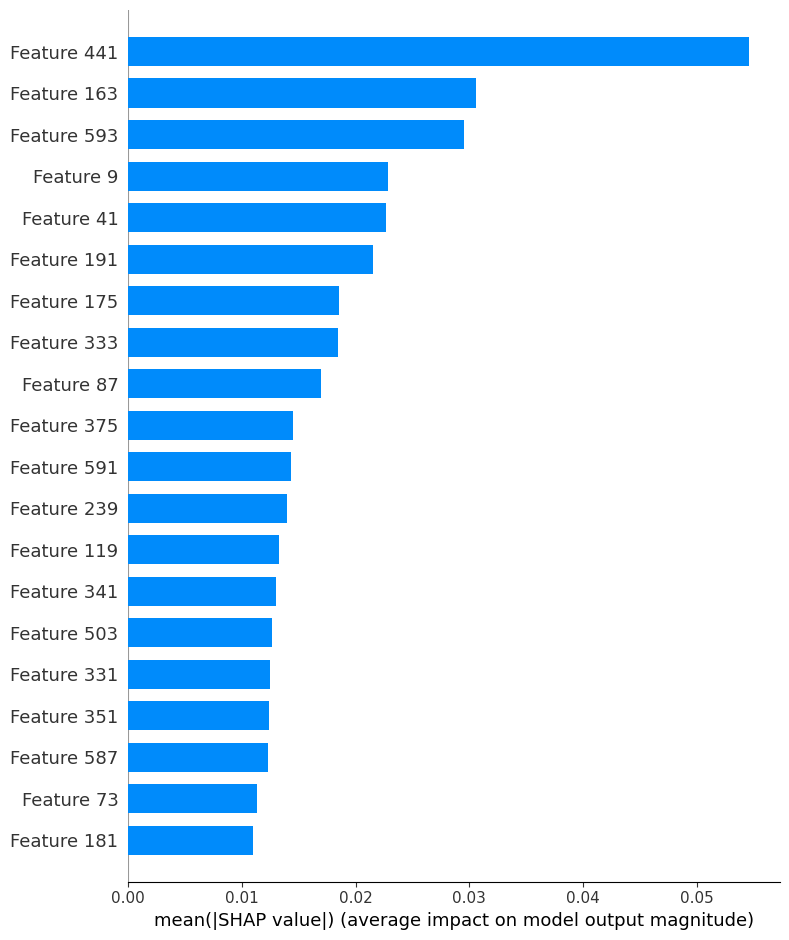

In [ ]:
import shap

explainer = shap.KernelExplainer(classifier_gunpoint.predict, x_train_transformed_gunpoint)
shap_values = explainer.shap_values(x_test_transformed_gunpoint)

# Visualize SHAP values
shap.summary_plot(shap_values, x_test_transformed_gunpoint, plot_type="bar")
plt.show()

In [ ]:


def calculate_feature_impacts(coefs, x_test_transform ):
    """Calculate the impacts of features on the instance at the given index."""
    feature_impacts = coefs * x_test_transform
    return feature_impacts



def select_and_segment_features(feature_impacts, n_top_coef, kernel_size, ts_idx):

    top_positive_indices = np.argsort(feature_impacts[ts_idx, :])[::-1][:n_top_coef]
    significant_positive_features = top_positive_indices


    positive_features_below_kernel_size = significant_positive_features < kernel_size
    positive_features_above_kernel_size = significant_positive_features >= kernel_size


    halved_indices_below_kernel_size_pos = significant_positive_features[positive_features_below_kernel_size] / 2
    halved_indices_above_kernel_size_pos = significant_positive_features[positive_features_above_kernel_size] / 2
    indices_below_kernel_size_pos = halved_indices_below_kernel_size_pos.astype(int)
    indices_above_kernel_size_pos = halved_indices_above_kernel_size_pos.astype(int)


    top_negative_indices = np.argsort(feature_impacts[ts_idx, :])[:n_top_coef]
    significant_negative_features = top_negative_indices


    negative_features_below_kernel_size = significant_negative_features < kernel_size
    negative_features_above_kernel_size = significant_negative_features >= kernel_size

    halved_indices_below_kernel_size_neg = significant_negative_features[negative_features_below_kernel_size] / 2
    halved_indices_above_kernel_size_neg = significant_negative_features[negative_features_above_kernel_size] / 2
    indices_below_kernel_size_neg = halved_indices_below_kernel_size_neg.astype(int)
    indices_above_kernel_size_neg = halved_indices_above_kernel_size_neg.astype(int)

    return positive_features_below_kernel_size, positive_features_above_kernel_size, indices_below_kernel_size_pos, indices_above_kernel_size_pos, negative_features_below_kernel_size, negative_features_above_kernel_size, indices_below_kernel_size_neg, indices_above_kernel_size_neg




def calculate_contributions(coefs, indices, feature_indices, ts_idx, x_test_transform):

    valid_indices = feature_indices[feature_indices < len(coefs)]
    valid_indices = valid_indices[valid_indices < x_test_transform.shape[1]]

    contributions = np.abs(coefs[valid_indices])
    contribution_values = contributions * x_test_transform[ts_idx, valid_indices]

    return contribution_values




In [ ]:

coefs = classifier_gunpoint.coef_.reshape(classifier_gunpoint.coef_.shape[1])
percentage_chosen_coefficients = 0.2
n_top_coef = int(len(coefs) * percentage_chosen_coefficients)
kernel_size = 100


ts_idx = 51


feature_impacts = calculate_feature_impacts(coefs, x_test_transformed_gunpoint)
pred_selected_instance = classifier_gunpoint.predict(x_test_transformed_gunpoint[ts_idx, :].reshape(1, -1))
print("predicted class:", pred_selected_instance)


(positive_features_below_kernel_size, positive_features_above_kernel_size,
 indices_below_kernel_size_pos, indices_above_kernel_size_pos,
 negative_features_below_kernel_size, negative_features_above_kernel_size,
 indices_below_kernel_size_neg, indices_above_kernel_size_neg) = select_and_segment_features(feature_impacts, n_top_coef, kernel_size, ts_idx)


print("#Gunpoint kernels from features below kernel size for positive class:", np.sum(positive_features_below_kernel_size))
print("#Gunpoint kernels from features above kernel size for positive class:", np.sum(positive_features_above_kernel_size))
print("#Gunpoint kernels from features below kernel size for negative class:", np.sum(negative_features_below_kernel_size))
print("#Gunpoint kernels from features above kernel size for negative class:", np.sum(negative_features_above_kernel_size))

contributions_below_kernel_size_pos = calculate_contributions(coefs, indices_below_kernel_size_pos, indices_below_kernel_size_pos, ts_idx, x_test_transformed_gunpoint)
contributions_above_kernel_size_pos = calculate_contributions(coefs, indices_above_kernel_size_pos, indices_above_kernel_size_pos, ts_idx, x_test_transformed_gunpoint)
contributions_below_kernel_size_neg = calculate_contributions(coefs, indices_below_kernel_size_neg, indices_below_kernel_size_neg, ts_idx, x_test_transformed_gunpoint)
contributions_above_kernel_size_neg = calculate_contributions(coefs, indices_above_kernel_size_neg, indices_above_kernel_size_neg, ts_idx, x_test_transformed_gunpoint)




predicted class: [1]
#Gunpoint kernels from features below kernel size for positive class: 20
#Gunpoint kernels from features above kernel size for positive class: 100
#Gunpoint kernels from features below kernel size for negative class: 19
#Gunpoint kernels from features above kernel size for negative class: 101


In [ ]:
def dilate_kernel(weights, dilation):

    length = len(weights)
    receptive_field = int((length - 1) * dilation + 1)
    kernel_dilated = np.zeros(receptive_field)
    index = 0

    for j in range(length):
        kernel_dilated[index] = weights[j]
        index = index + dilation

    return kernel_dilated


def feature_map_kernel_pad(X, weights, length, bias, dilation, padding):

    input_length = len(X)
    receptive_field = int((length - 1) * dilation + 1)

    rf_padding = np.zeros(int((receptive_field - 1)/2))
    X_padded = np.concatenate((rf_padding, X, rf_padding), axis=None)

    indices_contributors = []
    values_contributors = []

    fm_single_kernel = np.zeros(input_length)
    kernel_dilated = dilate_kernel(weights,dilation)

    for t in range(input_length):
        fm_single_kernel[t] = bias + np.inner(kernel_dilated, X_padded[t:t+receptive_field])

        indices_contributors.append(t + np.nonzero(kernel_dilated)[0] - int((receptive_field - 1)/2))
        values_contributors.append(fm_single_kernel[t])

    return fm_single_kernel, indices_contributors, values_contributors

def feature_map_kernel_nopad(X, weights, length, bias, dilation, padding):

    input_length = len(X)
    receptive_field = int((length - 1) * dilation + 1)

    indices_contributors = []
    values_contributors = []

    fm_single_kernel = np.zeros(input_length)
    kernel_dilated = dilate_kernel(weights,dilation)

    for t in range(input_length - receptive_field + 1):
        fm_single_kernel[t] = bias + np.inner(kernel_dilated, X[t:t+receptive_field])

        indices_contributors.append(t + np.nonzero(kernel_dilated)[0])
        values_contributors.append(fm_single_kernel[t])

    return fm_single_kernel, indices_contributors, values_contributors


def calc_features_contribution(indices_contributors, values_contributors, length_ts):

    contributions = np.empty([length_ts,length_ts])
    contributions[:] = np.nan
    contributions_dividor = np.ones([length_ts,length_ts])

    ppv_absolute = np.sum(np.array(values_contributors) > 0)

    for i in range(len(values_contributors)):

        indices = indices_contributors[i]

        for j in indices:
            if j >= 0 and j < length_ts:
                contributions[i,j] = values_contributors[i]
                contributions_dividor[i,j] = len(indices)

    contributions_ppv = contributions.copy()
    positive_entries = contributions_ppv > 0
    contributions_ppv[positive_entries] = 1
    contributions_ppv[~positive_entries] = 0
    contributions_ppv_feat = np.any(contributions_ppv >0, axis=0)
    if ~np.all(contributions_ppv_feat == 0):
        contributions_ppv_feat = contributions_ppv_feat / np.nansum(contributions_ppv_feat)

    contributions_mv_feat = np.nanmax(contributions, axis = 0)
    max_val_ind = contributions_mv_feat == np.max(contributions_mv_feat)
    contributions_mv_feat[max_val_ind] = 1
    contributions_mv_feat[~max_val_ind] = 0
    if ~np.all(contributions_mv_feat == 0):
        contributions_mv_feat = contributions_mv_feat / np.nansum(contributions_mv_feat)

    return contributions_ppv_feat, contributions_mv_feat


def feature_map_xAI(X, kernels, inds):
    weights, lengths, biases, dilations, paddings = kernels
    fm_array = []
    features_contribution_ppv = []
    features_contribution_mv = []

    for j in inds:
        a1 = sum(lengths[:j])
        b1 = sum(lengths[:j + 1])
        wlts = weights[a1:b1]

        if paddings[j] == 0:
            fm_single_kernel, indices_contributors, values_contributors = feature_map_kernel_nopad(X, wlts, lengths[j], biases[j], dilations[j], paddings[j])
        else:
            fm_single_kernel, indices_contributors, values_contributors = feature_map_kernel_pad(X, wlts, lengths[j], biases[j], dilations[j], paddings[j])

        fm_array.append(fm_single_kernel)

        contributions_ppv, contributions_mv = calc_features_contribution(indices_contributors, values_contributors, len(X))

        features_contribution_ppv.append(contributions_ppv)
        features_contribution_mv.append(contributions_mv)

    fm_array_arr = np.array(fm_array)
    features_contribution_arr_ppv = np.vstack(np.array(features_contribution_ppv))
    features_contribution_arr_mv = np.vstack(np.array(features_contribution_mv))

    return fm_array_arr, features_contribution_arr_ppv, features_contribution_arr_mv




In [ ]:




def select_kernels_with_mutual_info(features_contribution_ppv, features_contribution_mv, num_kernels, y, threshold=0.1):
    """
    Identify the important kernels based on the contribution scores and mutual information.
    """
    num_important_kernels = int(num_kernels * threshold)

    mi_ppv = []
    mi_mv = []

    for i in range(features_contribution_ppv.shape[0]):
        mi_ppv.append(mutual_info_regression(features_contribution_ppv[i].reshape(-1, 1), y))

    for i in range(features_contribution_mv.shape[0]):
        mi_mv.append(mutual_info_regression(features_contribution_mv[i].reshape(-1, 1), y))

    mi_ppv = np.array(mi_ppv).flatten()
    mi_mv = np.array(mi_mv).flatten()

    importance_score_ppv = np.sum(features_contribution_ppv, axis=1) * mi_ppv
    importance_score_mv = np.sum(features_contribution_mv, axis=1) * mi_mv

    important_kernel_indices_ppv = np.argsort(importance_score_ppv)[::-1][:num_important_kernels]
    important_kernel_indices_mv = np.argsort(importance_score_mv)[::-1][:num_important_kernels]

    return important_kernel_indices_ppv, important_kernel_indices_mv

def get_kernel_parameters(important_kernel_indices, kernels):
    """
    Get the parameters of the important kernels.
    """
    weights, lengths, biases, dilations, paddings = kernels
    #print("Shapes of the kernel parameter arrays:")
    #print(f"weights.shape: {weights.shape}")
    #print(f"lengths.shape: {lengths.shape}")
    #print(f"biases.shape: {biases.shape}")
    #print(f"dilations.shape: {dilations.shape}")
    #print(f"paddings.shape: {paddings.shape}")

    kernel_parameters = []
    start_idx = 0
    for idx in important_kernel_indices:
        kernel_length = lengths[idx]
        end_idx = start_idx + kernel_length
        kernel_weights = weights[start_idx:end_idx]
        kernel_bias = biases[idx]
        kernel_dilation = dilations[idx]
        kernel_padding = paddings[idx]

        #print(f"Kernel {idx}:")
        #print(f"kernel_length: {kernel_length}")
        #print(f"kernel_weights.shape: {kernel_weights.shape}")
        #print(f"kernel_bias: {kernel_bias}")
        #print(f"kernel_dilation: {kernel_dilation}")
        #print(f"kernel_padding: {kernel_padding}")

        kernel_parameters.append((kernel_length, kernel_weights, kernel_bias, kernel_dilation, kernel_padding))
        start_idx = end_idx
    return kernel_parameters



def  map_kernels_to_input_with_shap(kernel_parameters, input_ts, shap_values):
    input_length = input_ts.shape[1]
    mapped_kernels = []

    for kernel_length, kernel_weights, kernel_bias, kernel_dilation, kernel_padding in kernel_parameters:
        receptive_field = int((kernel_length - 1) * kernel_dilation + 1)
        kernel_dilated = dilate_kernel(kernel_weights, kernel_dilation)
        input_mappings = []
        for t in range(input_length - receptive_field + 1):
            input_slice = input_ts[0, t:t+receptive_field]
            kernel_value = kernel_bias + np.inner(kernel_dilated, input_slice)
            shap_contribution = np.sum(shap_values[t:t+receptive_field])

            input_mappings.append((t, kernel_value, shap_contribution))
        mapped_kernels.append(input_mappings)

    return mapped_kernels



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifierCV


fm_ROCKET, features_contribution_1_pos_ppv_p, features_contribution_1_pos_mv = feature_map_xAI(x_test_gunpoint[ts_idx], kernels_gunpoint, indices_below_kernel_size_pos)



fm_ROCKET, features_contribution_2_pos_ppv_p, features_contribution_2_pos_mv = feature_map_xAI(x_test_gunpoint[ts_idx], kernels_gunpoint, indices_above_kernel_size_pos)


fm_ROCKET, features_contribution_1_neg_ppv_p, features_contribution_1_neg_mv = feature_map_xAI(x_test_gunpoint[ts_idx], kernels_gunpoint, indices_below_kernel_size_neg)



fm_ROCKET, features_contribution_2_neg_ppv_p, features_contribution_2_neg_mv = feature_map_xAI(x_test_gunpoint[ts_idx], kernels_gunpoint, indices_above_kernel_size_neg)



<ipython-input-14-9c136eb3cc75>:82: RuntimeWarning: All-NaN slice encountered
  contributions_mv_feat = np.nanmax(contributions, axis = 0)


In [ ]:

important_kernel_indices_ppv, important_kernel_indices_mv = select_kernels_with_mutual_info(features_contribution_2_neg_ppv_p, features_contribution_2_neg_mv , len(indices_above_kernel_size_neg), y_test_encoded_gunpoint, threshold=0.2)


input_ts = x_test_transformed_gunpoint[0].reshape(1, -1)
shap_values_for_input = explainer.shap_values(input_ts)[0]

kernels = kernels_gunpoint

kernel_parameters_ppv_k = get_kernel_parameters(important_kernel_indices_ppv, kernels)


mapped_kernels_ppv = map_kernels_to_input_with_shap(kernel_parameters_ppv_k, input_ts, shap_values_for_input)

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


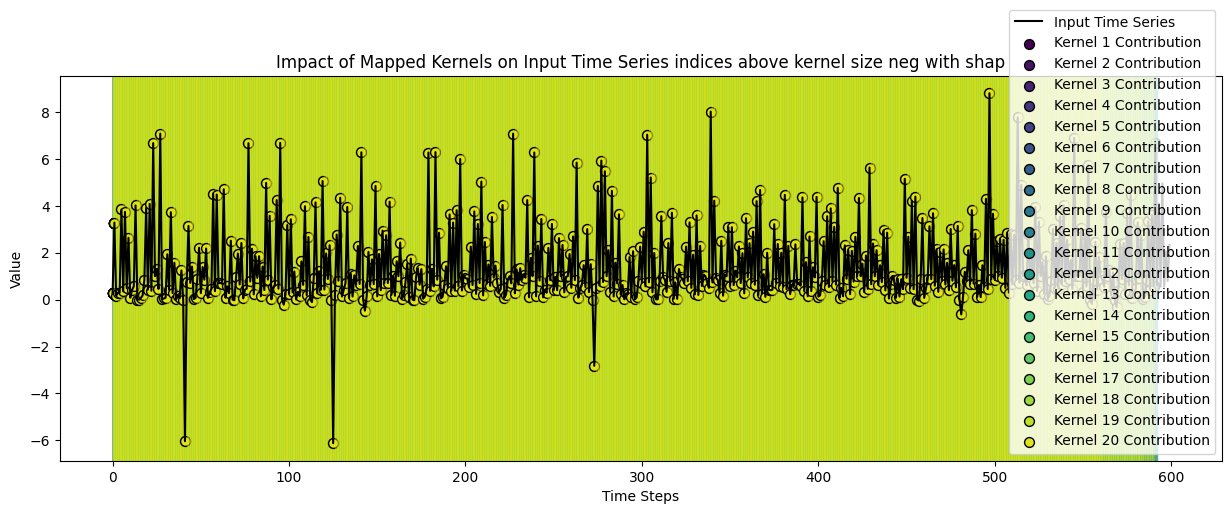

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


#Meng, H., Wagner, C. & Triguero, I. (2023), ‘Explaining time series classi- fiers through meaningful
#perturbation and optimisation’, Information Sci- ences 645, 119334.

# @article{meng2023explaining,
#  title={Explaining time series classifiers through meaningful perturbation and optimisation},
#  author={Meng, Han and Wagner, Christian and Triguero, Isaac},
#  journal={Information Sciences},
#  volume={645},
#  pages={119334},
#  year={2023},
#  publisher={Elsevier}
#}

def visualize_kernel_impact(input_ts, mapped_kernels):
    time_steps = np.arange(input_ts.shape[1])
    input_series = input_ts[0]

    plt.figure(figsize=(15, 5))
    plt.plot(time_steps, input_series, label='Input Time Series', color='black')

    # Color map for kernels
    cmap = plt.get_cmap('viridis')
    num_kernels = len(mapped_kernels)

    for i, kernel_mappings in enumerate(mapped_kernels):
        color = cmap(i / num_kernels)
        for t, kernel_value, shap_contribution in kernel_mappings:
            plt.axvspan(t, t + 1, color=color, alpha=0.3)
            plt.scatter(t, input_series[t], color=color, edgecolor='black', s=50, label=f'Kernel {i+1} Contribution' if t == 0 else '')

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Impact of Mapped Kernels on Input Time Series indices above kernel size neg with shap')
    plt.show()


visualize_kernel_impact(input_ts, mapped_kernels_ppv)

In [ ]:

#Sivill, T. & Flach, P. (2022), Limesegment: Meaningful, realistic time series ex- planations, in
#‘International Conference on Artificial Intelligence and Statis- tics’, PMLR, pp. 3418–3433.

# @inproceedings{sivill2022limesegment,
#  title={Limesegment: Meaningful, realistic time series explanations},
#  author={Sivill, Torty and Flach, Peter},
#  booktitle={International Conference on Artificial Intelligence and Statistics},
#  pages={3418--3433},
#  year={2022},
#  organization={PMLR}
#}


def add_noise_segment(x, start, end, noise_level=0.1):
    x_modified = x.copy()
    x_modified[start:end] += np.random.normal(0, noise_level, end - start)
    return x_modified


def calculate_faithfulness_with_noise(model, X_test, important_segments):
    original_confidences = model.decision_function(X_test)
    modified_confidences = []

    for i, x in enumerate(X_test):
        if i >= len(important_segments):
            break
        start, end = important_segments[i]
        if start >= end or start < 0 or end > len(x):
            continue

        x_modified = add_noise_segment(x, start, end)

        confidence_original = model.decision_function([x])[0]
        confidence_modified = model.decision_function([x_modified])[0]

        confidence_drop = confidence_original - confidence_modified
        modified_confidences.append(confidence_drop)


    faithfulness_mean = np.mean(modified_confidences)

    if len(modified_confidences) > 1:
        res = bootstrap((np.array(modified_confidences),), np.mean, confidence_level=0.95, n_resamples=1000)
        margin_of_error = (res.confidence_interval.high - res.confidence_interval.low) / 2
    else:
        margin_of_error = np.nan

    return faithfulness_mean, margin_of_error


important_segments = []
for kernel_mappings in mapped_kernels_ppv:
    for mapping in kernel_mappings:
        if isinstance(mapping, tuple) and len(mapping) >= 2:
            start = mapping[0]
            receptive_field = int((kernel_parameters_ppv_k[0][0] - 1) * kernel_parameters_ppv_k[0][3] + 1)
            important_segments.append((start, start + receptive_field))



if len(important_segments) < len(x_test_transformed_gunpoint):
    important_segments = important_segments * (len(x_test_transformed_gunpoint) // len(important_segments)) + important_segments[:len(x_test_transformed_gunpoint) % len(important_segments)]


faithfulness, faithfulness_error = calculate_faithfulness_with_noise(classifier_gunpoint, x_test_transformed_gunpoint, important_segments)
print(f"Faithfulness: {faithfulness:.4f} ± {faithfulness_error:.4f}")

Faithfulness: -0.0003 ± 0.0017


In [ ]:

#Sivill, T. & Flach, P. (2022), Limesegment: Meaningful, realistic time series ex- planations, in
#‘International Conference on Artificial Intelligence and Statis- tics’, PMLR, pp. 3418–3433.

# @inproceedings{sivill2022limesegment,
#  title={Limesegment: Meaningful, realistic time series explanations},
#  author={Sivill, Torty and Flach, Peter},
#  booktitle={International Conference on Artificial Intelligence and Statistics},
#  pages={3418--3433},
#  year={2022},
#  organization={PMLR}
#}

def calculate_robustness(original_mapped_kernels, perturbed_mapped_kernels):
    robustness_values = []
    for original, perturbed in zip(original_mapped_kernels, perturbed_mapped_kernels):
        original_values = np.array([value for _, value in original])
        perturbed_values = np.array([value for _, value in perturbed])


        if len(original_values) != len(perturbed_values):
            print("Error: Mismatch in length between original and perturbed values")
            continue

        if np.isnan(original_values).any() or np.isnan(perturbed_values).any():
            print("Error: NaN values found in original or perturbed values")
            continue

        robustness = np.mean(np.abs(original_values - perturbed_values))
        robustness_values.append(robustness)


    robustness_values = [val for val in robustness_values if not np.isnan(val)]
    if not robustness_values:
        raise ValueError("All robustness values are NaN or the list is empty.")

    robustness_mean = np.mean(robustness_values)

    if len(robustness_values) <= 1:
        raise ValueError("Not enough observations for bootstrap. At least two observations are required.")


    res = bootstrap((np.array(robustness_values),), np.mean, confidence_level=0.95, n_resamples=1000)
    margin_of_error = (res.confidence_interval.high - res.confidence_interval.low) / 2

    return robustness_mean, margin_of_error

def explanations_unchanged(original_mapped_kernels, perturbed_mapped_kernels, threshold=0.01):
    unchanged_count = 0
    for original, perturbed in zip(original_mapped_kernels, perturbed_mapped_kernels):
        original_values = np.array([value for _, value in original])
        perturbed_values = np.array([value for _, value in perturbed])
        if np.all(np.abs(original_values - perturbed_values) < threshold):
            unchanged_count += 1
    return unchanged_count



def evaluate_robustness_with_perturbations(kernel_parameters, input_ts, shap_values, num_perturbations=50, threshold=0.01):
    robustness_values = []
    unchanged_proportions = []

    mapped_kernels_ppv = map_kernels_to_input_with_shap(kernel_parameters, input_ts, shap_values)

    for _ in range(num_perturbations):
        perturbation = np.random.normal(0, 0.2, input_ts.shape)
        perturbed_input_ts = input_ts + perturbation

        perturbed_mapped_kernels = map_kernels_to_input_with_shap(kernel_parameters, perturbed_input_ts, shap_values)

        robustness, _ = calculate_robustness(mapped_kernels_ppv, perturbed_mapped_kernels)
        robustness_values.append(robustness)

        unchanged_count = explanations_unchanged(mapped_kernels_ppv, perturbed_mapped_kernels, threshold)
        unchanged_proportions.append(unchanged_count / len(mapped_kernels_ppv))

    robustness_mean = np.mean(robustness_values)
    unchanged_proportion_mean = np.mean(unchanged_proportions)

    res_robustness = bootstrap((np.array(robustness_values),), np.mean, confidence_level=0.95, n_resamples=1000)
    robustness_margin_of_error = (res_robustness.confidence_interval.high - res_robustness.confidence_interval.low) / 2

    res_proportion = bootstrap((np.array(unchanged_proportions),), np.mean, confidence_level=0.95, n_resamples=1000)
    proportion_margin_of_error = (res_proportion.confidence_interval.high - res_proportion.confidence_interval.low) / 2

    return robustness_mean, robustness_margin_of_error, unchanged_proportion_mean, proportion_margin_of_error


robustness_mean, robustness_margin_of_error, unchanged_proportion_mean, proportion_margin_of_error = evaluate_robustness_with_perturbations(
    kernel_parameters_ppv_k, input_ts, shap_values, num_perturbations=10
)


print(f"Robustness: {robustness_mean:.4f} ± {robustness_margin_of_error:.4f}")


Robustness: 0.0011 ± 0.0000
